# GBDT baselines - catBoost

- 작성일: 240108
- 작성자: 이주연

특이 사항
- 평가 데이터를 학습/평가 데이터 전처리에 사용함
- user, tag, item, test의 평균 정답률을 agg하여 사용함. 단 agg 시 label 데이터를 포함하지 않고 진행함.
- hyperparameter tuning 전혀 없이 default setting으로 진행. 단, categorical data는 명시.
- acc: 0.6888, AUROC: 0.7507

In [1]:
import os, random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

### data load

In [3]:
data_dir = '../data'

In [4]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

train_df.shape, test_df.shape

((2266586, 6), (260114, 6))

## preprocessing

In [5]:
# # 누적 카운트
# train_df['cumcount'] = train_df.groupby('userID').cumcount()
# test_df['cumcount'] = test_df.groupby('userID').cumcount()

# drop Timestamp
train_df = train_df.drop(columns=['Timestamp'])
test_df = test_df.drop(columns=['Timestamp'])

In [6]:
# split label
train_label = train_df.drop_duplicates(subset=['userID'], keep='last')
test_label = test_df.drop_duplicates(subset=['userID'], keep='last')

# drop labels
train_df = train_df.drop(index=train_label.index)
test_df = test_df.drop(index=test_label.index)
base_df = pd.concat([train_df, test_df], axis=0)

base_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'KnowledgeTag'], dtype='object')

### aggregation

In [7]:
# agg
base_user_agg = base_df.groupby('userID').agg(
    avg_acc=('answerCode','mean'), 
    total_test=('answerCode','count'),
)
base_user_agg.head()

,avg_acc,total_test
userID,,
0,0.631720,744
1,0.853004,932
2,0.614545,275
3,0.692754,1035
4,0.694030,670


In [8]:
base_tag_agg = base_df.groupby('KnowledgeTag').agg(tag_acc=('answerCode','mean'))
base_tag_agg.head()

,tag_acc
KnowledgeTag,
23,0.592593
24,0.625000
25,0.850000
26,0.611193
30,0.530000


In [9]:
base_item_agg = base_df.groupby('assessmentItemID').agg(item_acc=('answerCode','mean'))
base_item_agg.head()

,item_acc
assessmentItemID,
A010001001,0.922857
A010001002,0.960000
A010001003,0.905714
A010001004,0.945714
A010001005,0.882857


In [10]:
base_test_agg = base_df.groupby('testId').agg(test_acc=('answerCode','mean'))
base_test_agg.head()

,test_acc
testId,
A010000001,0.923429
A010000002,0.931429
A010000003,0.842857
A010000004,0.880571
A010000005,0.849143


In [11]:
base_tabular = pd.merge(train_label, base_user_agg, left_on='userID', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
base_tabular = pd.merge(base_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
base_tabular.head()

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,avg_acc,total_test,tag_acc,item_acc,test_acc
744,0,A080129006,A080000129,0,2725,0.631720,744,0.303871,0.156593,0.362708
1677,1,A090074006,A090000074,1,2648,0.853004,932,0.451737,0.478261,0.436567
1953,2,A050139007,A050000139,0,428,0.614545,275,0.678480,0.125000,0.626797
2786,5,A080138007,A080000138,1,8431,0.795673,832,0.472861,0.554622,0.499468
3707,6,A030145005,A030000145,0,7817,0.443478,920,0.616850,0.615120,0.627767


In [12]:
# train merge
train_tabular = pd.merge(train_label, base_user_agg, left_on='userID', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
train_tabular = pd.merge(train_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
train_tabular.head()

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,avg_acc,total_test,tag_acc,item_acc,test_acc
744,0,A080129006,A080000129,0,2725,0.631720,744,0.303871,0.156593,0.362708
1677,1,A090074006,A090000074,1,2648,0.853004,932,0.451737,0.478261,0.436567
1953,2,A050139007,A050000139,0,428,0.614545,275,0.678480,0.125000,0.626797
2786,5,A080138007,A080000138,1,8431,0.795673,832,0.472861,0.554622,0.499468
3707,6,A030145005,A030000145,0,7817,0.443478,920,0.616850,0.615120,0.627767


In [13]:
# train merge
test_tabular = pd.merge(test_label, base_user_agg, left_on='userID', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_tag_agg, left_on='KnowledgeTag', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_item_agg, left_on='assessmentItemID', right_index=True, how='left')
test_tabular = pd.merge(test_tabular, base_test_agg, left_on='testId', right_index=True, how='left')
test_tabular.head()

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,avg_acc,total_test,tag_acc,item_acc,test_acc
1035,3,A050133008,A050000133,-1,5289,0.692754,1035,0.559729,0.536290,0.655656
1706,4,A070146008,A070000146,-1,9080,0.694030,670,0.548426,0.605839,0.651477
3023,13,A070111008,A070000111,-1,9660,0.695289,1316,0.495308,0.369478,0.456957
4283,17,A090064006,A090000064,-1,2611,0.818904,1259,0.422518,0.274725,0.449915
4670,26,A060135007,A060000135,-1,1422,0.759067,386,0.611052,0.315126,0.642693


In [14]:
# astype categorical data
category_columns = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag']

train_tabular[category_columns] = train_tabular[category_columns].astype("category")
test_tabular[category_columns] = test_tabular[category_columns].astype("category")

In [15]:
# define X, y data
X_train = train_tabular.drop(columns='answerCode')
y_train = train_tabular[['answerCode']]

X_test = test_tabular.drop(columns='answerCode')

## train/valid split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, shuffle=True)

X_train.shape, X_valid.shape

((5358, 9), (1340, 9))

In [18]:
X_train.head()

,userID,assessmentItemID,testId,KnowledgeTag,avg_acc,total_test,tag_acc,item_acc,test_acc
1919639,3808,A080091008,A080000091,7118,0.515385,130,0.382872,0.360406,0.540701
1123856,1724,A010152005,A010000152,7801,0.869885,953,0.811954,0.764706,0.805172
2247625,6680,A040163005,A040000163,2120,0.586207,29,0.738293,0.341216,0.778075
2120114,4948,A080129006,A080000129,2725,0.289720,107,0.303871,0.156593,0.362708
1879747,3654,A070130008,A070000130,9067,0.761719,256,0.595698,0.632911,0.574522


## train catBoost with default setting

In [19]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [20]:
model = CatBoostClassifier(
    custom_loss='AUC',
    logging_level='Silent',
    od_type='Iter',
    od_wait=40
)

In [21]:
model.fit(
    X_train, y_train,
    cat_features=category_columns,
    eval_set=(X_valid, y_valid),
    logging_level='Verbose',  # you can uncomment this for text output
)

Learning rate set to 0.04797
0:	learn: 0.6854774	test: 0.6855637	best: 0.6855637 (0)	total: 58.2ms	remaining: 58.1s
1:	learn: 0.6779089	test: 0.6780772	best: 0.6780772 (1)	total: 66.4ms	remaining: 33.1s
2:	learn: 0.6707682	test: 0.6711868	best: 0.6711868 (2)	total: 74.6ms	remaining: 24.8s
3:	learn: 0.6646152	test: 0.6648829	best: 0.6648829 (3)	total: 82.3ms	remaining: 20.5s
4:	learn: 0.6591281	test: 0.6595120	best: 0.6595120 (4)	total: 90.1ms	remaining: 17.9s
5:	learn: 0.6538810	test: 0.6542003	best: 0.6542003 (5)	total: 97.6ms	remaining: 16.2s
6:	learn: 0.6498505	test: 0.6503221	best: 0.6503221 (6)	total: 105ms	remaining: 14.9s
7:	learn: 0.6458639	test: 0.6461908	best: 0.6461908 (7)	total: 113ms	remaining: 14s
8:	learn: 0.6425662	test: 0.6429983	best: 0.6429983 (8)	total: 120ms	remaining: 13.2s
9:	learn: 0.6392762	test: 0.6396092	best: 0.6396092 (9)	total: 127ms	remaining: 12.5s
10:	learn: 0.6356736	test: 0.6360253	best: 0.6360253 (10)	total: 134ms	remaining: 12s
11:	learn: 0.6325993	

(array([2787.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2571.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

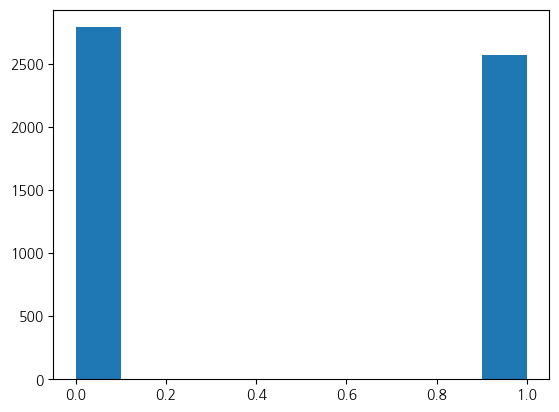

In [22]:
plt.hist(y_train, label='train')

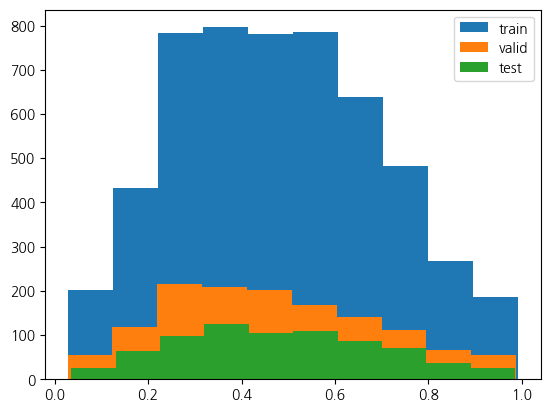

In [23]:
# predict proba histogram
plt.hist(model.predict_proba(X_train)[:,1], label='train')
plt.hist(model.predict_proba(X_valid)[:,1], label='valid')
plt.hist(model.predict_proba(X_test)[:,1], label='test')
plt.legend()
plt.show()

## evaluation by validation data

### get optimal threshold with auroc curve

In [24]:
from sklearn.metrics import roc_curve, auc
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(X_valid)[:,1])
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.4671791588228435

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [26]:
acc = accuracy_score(y_valid, model.predict(X_valid))
auroc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])

print(f'acc: {acc:.4f}, AUROC: {auroc:.4f}')

acc: 0.6888, AUROC: 0.7507


## understand the results

### confusion matrix

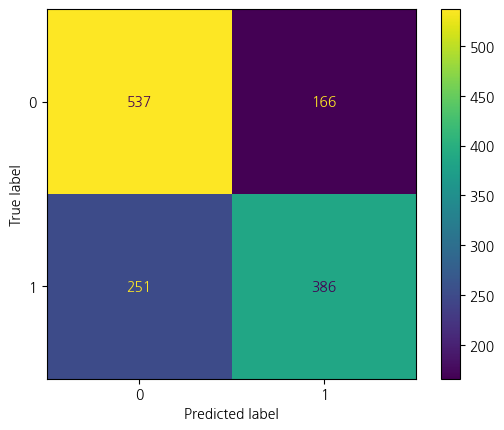

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cmd = ConfusionMatrixDisplay(confusion_matrix(y_valid, model.predict(X_valid)))
cmd.plot()

### feature importance

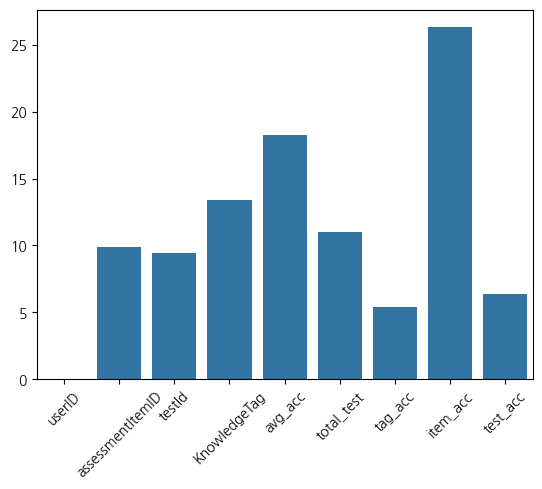

In [28]:
sns.barplot( model.get_feature_importance())
plt.xticks(ticks=range(len(X_train.columns)), 
           labels=X_train.columns, rotation=45)
plt.show()

## save submissions

In [29]:
submission_df.prediction = model.predict_proba(test_tabular.drop(columns=['answerCode']))[:,1]

In [30]:
from datetime import datetime as dt
now = dt.strftime(dt.now(), '%y%m%d-%H%M%S')

In [31]:
modelname = 'catBoost'
result_dir = '../results/'
submission_df.to_csv(os.path.join(result_dir, f'{modelname}-{auroc:.4f}-{now}.csv'), index=False)